Trying to open saved data.
Loading a subset with  100  nodes.
Fitting first model (time only)
[  31.69180508   44.94237976   66.45392761 ...,   65.72812653   91.78492126
  120.4089798 ]
Fitting second model (other features)


/home/hobbs/.conda/envs/ugh/lib/python3.6/site-packages/ipykernel/__main__.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/hobbs/.conda/envs/ugh/lib/python3.6/site-packages/ipykernel/__main__.py:192: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


4
14
[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)]


/home/hobbs/.conda/envs/ugh/lib/python3.6/site-packages/ipykernel/__main__.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RMSE time delay only:
5.07961586606
RMSE time delay + features
5.06138775262
                                  dollar_mw       y_ts     y_full
node         time                                                
ALAMT4G_7_B1 2017-10-02 00:00:00  35.283878  30.184175  28.319812
             2017-10-02 01:00:00  49.763371  33.618034  34.662872
             2017-10-02 02:00:00  58.605629  49.171923  50.823064
             2017-10-02 03:00:00  44.077530  62.647497  62.696796
             2017-10-02 04:00:00  36.175529  50.247875  50.434281
WMAE time delay only:
                                      error  dollar_mw  abs_error  week
node         time                                                      
ALAMT4G_7_B1 2017-10-02 00:00:00  -5.099703  35.283878   5.099703    40
             2017-10-02 01:00:00 -16.145336  49.763371  16.145336    40
             2017-10-02 02:00:00  -9.433706  58.605629   9.433706    40
             2017-10-02 03:00:00  18.569967  44.077530  18.569967    40
       

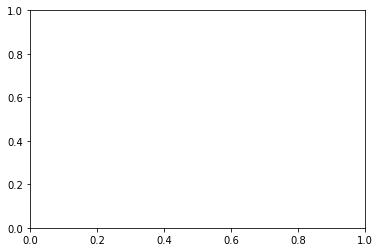

In [31]:
import pickle
import itertools
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import patsy
from sklearn import preprocessing, linear_model, model_selection, ensemble, metrics
from ggplot import *
from tqdm import tnrange, tqdm

def load_data(quick=True):

    def make_pickle():
        # Read csv
        df = pd.read_csv('nodes_final_data.csv')

        # Set the index
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index(['node', 'time'])

        # Create/ format some variables
        df['week'] = [value[1].isocalendar()[1] for value in df.index.values]

        # Save as a pickle
        df.to_pickle('nodes_final_data.p')

        return df

    if quick is True:
        try:
            print("Trying to open saved data.")
            with open('nodes_final_data.p', 'rb') as f:
                return pickle.load(f)

        except FileNotFoundError:
            print("No existing pickle found... picklemaking!")
            return make_pickle()
    else:
        print("Pickling a fresh new pickle.")
        return make_pickle()


def load_subset(n, df):
    print("Loading a subset with ", n, " nodes.")
    np.random.seed(seed=1)
    node_ids = df.index.get_level_values('node').unique()
    selected_nodes = list(np.random.choice(node_ids, size=n))
    return df.loc[selected_nodes]


def quick_patsy(arg, input_data, quick=True):
    #File will save with the patsy description and number of observations
    filename = arg + str(input_data.shape[1]) + '.p'
    if quick:
        try:
            with open(filename, 'rb') as f:
                y, X = pickle.load(f)
        except FileNotFoundError:
            with open(filename, 'wb') as f:
                y, X = tuple(
                    np.array(matrix)
                    for matrix in patsy.dmatrices(arg, data=input_data))
                pickle.dump((y, X), f)
    else:
        with open(filename, 'wb') as f:
            y, X = tuple(
                np.array(matrix)
                for matrix in patsy.dmatrices(arg, data=input_data))
            pickle.dump((y, X), f)

    y = np.array(y)
    X = np.array(X)
    return (y, X)


normalize = lambda x: (x - np.mean(x))/ np.std(x)

def lag_var(df, var, n_periods):
    return df[var].groupby(level='node').shift(n_periods)



df = load_subset(100, load_data())
#df.head()

df['temp_last_hr'] = lag_var(df, 'temp', 1)
df['price_last_hr'] = lag_var(df, 'dollar_mw', 1)
df['price_yesterday'] = lag_var(df, 'dollar_mw', 24)
df['price_last_week'] = lag_var(df, 'dollar_mw', 24 * 7)
df['nodenorm_temp'] = df['temp'].groupby(level = 'node').apply(normalize)
df['node'] = [value[0] for value in df.index.values]

lagnames = ''

for i in list(range(1, 24 * 7)):
    name = 'lag' + str(i)
    lagnames += name + ' + '
    df[name] = lag_var(df, 'dollar_mw', i)

# temperature bins
#bins = [np.min(df['nodenorm_temp']), -2, -1, 1, 2, np.max(df['nodenorm_temp'])]
#group_names = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
#df['temp_bin'] = pd.cut(df['nodenorm_temp'], bins, labels=group_names)

# drop NA values, since beginning and ends now lack variables
df = df.dropna()

# normalize features
#to_normalize = ['other_MW', 'solar_MW', 'wind_MW', 'latitude', 'longitude', 'temp']
#df[to_normalize] = df[to_normalize].apply(normalize)

df.head()

from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(y_actual, y_predicted):
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    return np.sqrt(rms)

def evaluate(train_index, test_index, model, X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fitted = model.fit(X_train, y_train)
    y_hat = fitted.predict(X_test)
    errors = np.subtract(y_test, y_hat)
    y_hat_all = fitted.predict(X)
    return [rmse(y_test, y_hat),  y_hat_all, errors]

def run_models(models, feature_sets, df, folds=8, parallel=True):
    '''
    Takes a list of models and features, and runs each model with each set of features
    Features should be patsy-formatted strings.

    Models should be a list of sci-kit learn models and the second
    the number of jobs that used for cross-validation.

    Data is 'df' (a pandas dataframe), and 'folds' is the number of folds that should be used
    for cross-validation.
    '''
    #iterate through all the models
    results = []
    kf = model_selection.KFold(n_splits=folds)
    for features in tqdm(feature_sets, desc = 'Feature Set'):
        y, X = patsy.dmatrices(features, data=df)
        y = np.array(y)
        X = preprocessing.scale(X)
        for model in tqdm(models, desc = "Models"):
            if parallel:
                result = Parallel(n_jobs=folds)(delayed(evaluate)(train_index, test_index, model, X, np.ravel(y)) for train_index, test_index in kf.split(X))
            else:
                result = [evaluate(train_index, test_index, model, X, np.ravel(y)) for train_index, test_index in kf.split(X)]
            scores = [res[0] for res in result]
            y_hat = [res[1] for res in result]
            errors = [res[2] for res in result]
            results.append({'model': model,
                            'features': features,
                            'score': np.mean(scores),
                            'y_hats': y_hat,
                            'errors': errors})

    return pd.DataFrame(results)

def train_new_model(models, feature_set1, feature_set2, df):

    #iterate through all the models
    print('Fitting first model (time only)')
    results = []
    y, X = patsy.dmatrices(feature_set1, data=df)
    #X = preprocessing.scale(X)
    y = np.array(y)
    model = models[0]
    fitted = model.fit(X, np.ravel(y))
    y_hat = fitted.predict(X)
    y_residu = np.ravel(y) - np.ravel(y_hat)

    results.append({'model': fitted, 'y_hats': y_hat, 'y_residu': y_residu})
    print(results[0]['y_hats'])
    print('Fitting second model (other features)')
    df_results_1 = pd.DataFrame(results)
    df['y_residu'] = df_results_1['y_residu'][0].ravel()
    #print(df)


    #print(df.columns)
    #print(df.keys())
    y, X = patsy.dmatrices(feature_set2, data=df)
    y = np.array(y)
    #X = preprocessing.scale(X)

    model = models[1]
    fitted = model.fit(X, y)
    results.append({'model': fitted})

    return results


def test_new_model(fitted_models, feature_set1, feature_set2, df):
    y, X = patsy.dmatrices(feature_set1, data=df, return_type = 'dataframe')
    index_values = y.index
    #y = np.array(y)
    y_hat = fitted_models[0].predict(X)
    df['y_residu'] = np.ravel(y) - np.ravel(y_hat)
    y2, X2 = patsy.dmatrices(feature_set2, data=df, return_type = 'dataframe')
    y_final = fitted_models[1].predict(X2)
    res = np.ravel(y) - np.ravel(y_final)
    #plt.plot(y_final + y_hat, label='model sum')
    #plt.plot(y_hat, label='estimate model 1')
    #plt.plot(y, label='original')
    #plt.plot(y_final, label='estimate model 2')
    #plt.plot(y.ravel() - y_hat.ravel(), label='residuals 1')
    #plt.grid()
    
    
    # Calculate y_hats and map to indices
    
    y_hat = pd.DataFrame(data = fitted_models[0].predict(X), index = index_values)
    y_final = pd.DataFrame(data = fitted_models[1].predict(X2), index = index_values)
    
    plt.legend()
    print('RMSE time delay only:')
    print(rmse(y, y_hat))
    print('RMSE time delay + features')
    print(rmse(y, y_final + y_hat))
    
    def wmae(little_df, df):
        # name is wrong as an artifact of how the thing was produced
        little_df = little_df.rename(columns={'dollar_mw': 'error'})
        # merge with prices
        little_df = pd.merge(little_df, df, left_index=True, right_index=True)

        # Get absolute value of the error
        little_df['abs_error'] = np.absolute(little_df['error'])
        # Get week index for grouping
        little_df['week']  = [date.isocalendar()[1] for date in little_df.index.get_level_values('time')]
        print(little_df.head())
        little_df = little_df.rename(columns={'0': 'dollar_mw'})
        return np.mean(little_df.groupby('week').mean()['abs_error']/little_df.groupby('week').mean()['dollar_mw'])
    
    
    error_df = y
    error_df['y_ts'] = y_hat.values
    error_df['y_full'] = y_hat.values + y_final.values
    
    print(error_df.head())
    

    print('WMAE time delay only:')
    error_df['error'] = error_df['y_ts'] - error_df['dollar_mw']
    
    print(wmae(pd.DataFrame(error_df['error']), pd.DataFrame(error_df['dollar_mw'])))
    print('WMAE time delay + features')
    error_df['error'] = error_df['y_full'] - error_df['dollar_mw']
    print(wmae(pd.DataFrame(error_df['error']), pd.DataFrame(error_df['dollar_mw'])))
    plt.show()


df_test = df[df['month'] >= 10]
df_train = df[df['month'] < 10]

# We first chose the model :
feature_sets1 = 'dollar_mw ~ price_last_hr + price_yesterday + price_last_week'
feature_sets2 = 'y_residu ~ other_MW + solar_MW + wind_MW + load_MW + fuel_price + opr_hr + day + temp + irrad + wind_u + wind_v + latitude + longitude'

model1 = ensemble.RandomForestRegressor(n_jobs = 4)
model2 = ensemble.RandomForestRegressor(n_jobs = 4)
results = train_new_model([model1, model2], feature_sets1, feature_sets2, df_train)
fitted_models = [v['model'] for v in results]
print(fitted_models[0].n_features_)
print(fitted_models[1].n_features_)
print(fitted_models)
test_new_model(fitted_models, feature_sets1, feature_sets2, df_test)